### Criação de modelo para reconhecimento de áudio

#### Objetivo: Acessibilidade

Reconhecimento de comandos de áudio.

[Download do Dataset (2.3 GB)](https://cdn3.gnarususercontent.com.br/3981-tensorflow-keras/Projeto/dataset_commands-002.gz)

Bibliotecas necessárias:

- tensorflow (tensorflow[and-cuda] para rodar com GPU)
- tensorflow-hub
- librosa

In [33]:
import tensorflow as tf
from pathlib import Path
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

#### Carregando os dados

Descompactando o arquivo com tar dentro da pasta "dataset".

In [ ]:
# !mkdir dataset
# !tar -xzf dataset_commands-002.gz -C dataset

In [14]:
DATA_DIR = Path('dataset')
os.path.exists(DATA_DIR)

True

Adquirindo os caminhos de cada áudio.

In [20]:
audios = []
labels = []

for path in DATA_DIR.iterdir():
    if path.is_dir():
        for audio_path in path.glob('*.wav'):
            audios.append(audio_path)
            labels.append(path.stem)

In [22]:
df = pd.DataFrame({
    'audio_paths': audios,
    'labels': labels
})

df.head()

,audio_paths,labels
0,dataset/tree/37fc5d97_nohash_0.wav,tree
1,dataset/tree/e6515415_nohash_1.wav,tree
2,dataset/tree/b0f5b16d_nohash_0.wav,tree
3,dataset/tree/9beccfc8_nohash_0.wav,tree
4,dataset/tree/a0f93943_nohash_0.wav,tree


In [32]:
unique_labels = np.unique(labels)

print(len(unique_labels))
unique_labels

36


array(['_background_noise_', 'backward', 'bed', 'bird', 'cat', 'dog',
       'down', 'eight', 'five', 'follow', 'forward', 'four', 'go',
       'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off',
       'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three',
       'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero'], dtype='<U18')

Distribuição das categorias dos áudios.

<Axes: xlabel='labels'>

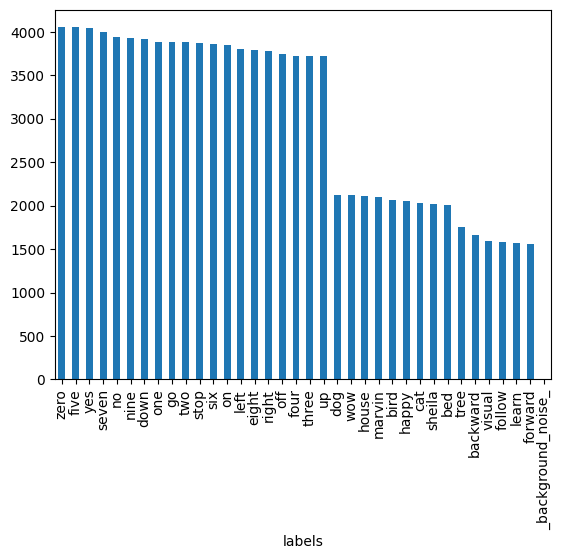

In [27]:
df['labels'].value_counts().plot.bar()

### Visualizando os arquivos de áudio

In [ ]:
example_audio_path = str(audios[0])

In [ ]:
# Arquivo binário de áudio
audio_binary = tf.io.read_file(example_audio_path)

# Decodificando o arquivo binário de áudio
audio, _ = tf.audio.decode_wav(audio_binary)

<tf.Tensor: shape=(), dtype=string, numpy=b'RIFF$}\x00\x00WAVEfmt \x10\x00\x00\x00\x01\x00\x01\x00\x80>\x00\x00\x00}\x00\x00\x02\x00\x10\x00data\x00}\x00\x00\xe9\xffi\xff\x8f\xff.\x00\x8c\x00\xb3\x00+\x00s\xff\x9e\xff\xe2\xff\xfb\xffN\x00K\x000\x00\xeb\xff\xbf\xff\xd4\xff\x01\x00\x0c\x00\x1c\x00^\x00\x05\x00o\xff_\xff\xdc\xff/\x00n\x00,\x00G\xff\x03\xff\xa5\xff^\x00O\x00\xff\xff\xc6\xff\x8d\xffa\xff\xc9\xff\xe4\xff\xd2\xff9\x00L\x00\x06\x00+\xff6\xff\x04\x00|\x00\'\x00~\xff\x96\xffA\xff\xc1\xff~\x00\xfa\xff\xe3\xff\xbe\xffm\xffL\xff\xb0\xff5\x00\xea\xffF\x00A\x00z\xff\x02\xff%\xff\xeb\xff\x17\x00F\x00K\x00\'\x00\x8d\xff\xc3\xfe\xfa\xfe\xbb\xff\xcb\x00\xa5\x00\xed\xff\x7f\xff\'\xffZ\xff\xce\xff\n\x00\x0c\x00$\x00\xee\xff\x0f\x00T\xff\xba\xfe\xe5\xff/\x00e\x00\xff\xffu\xff\xd1\xff\x88\xff\xee\xff\xdb\xff\x98\xff\xd1\xff\xb5\xff\xa4\xff\x86\xff\xdd\xff"\x00\x8f\xff/\xff\xa2\xff\xae\xff\xb3\xff\xf0\xffl\xffi\xff\xdf\xff\x9f\xff)\x00$\x00\x0b\xff.\xff\x8e\xff]\xff\xf9\xffW\x00\xba\xff\xae\x